<a href="https://colab.research.google.com/github/DataScientistTX/PyTorch_Projects/blob/main/PyTorch_class_ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

<ipython-input-1-0750ac4cbbd4>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)
loss_func = nn.CrossEntropyLoss()
device = torch.device("cuda")

<ipython-input-3-5fe39ac136da>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
def visualize2DSoftmax(X, y, model, title=None):
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32))
        y_hat = F.softmax(logits, dim=1).numpy()

    cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
    ax = plt.gca()
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax)
    if title is not None:
        ax.set_title(title)

In [5]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using.
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()

    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem

    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

In [6]:
def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [7]:
X_train, y_train = make_moons(n_samples=8000, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

In [8]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_pd = train_simple_network(model, loss_func, training_loader, epochs=5, test_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

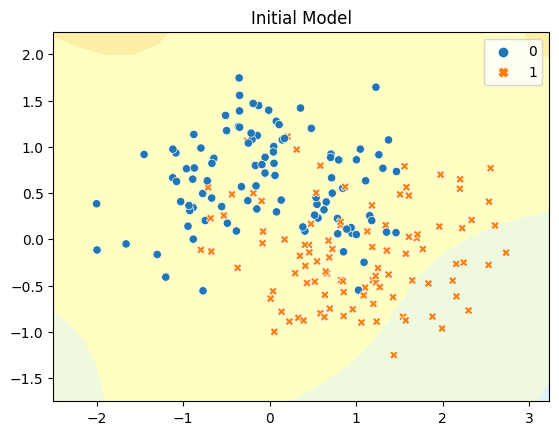

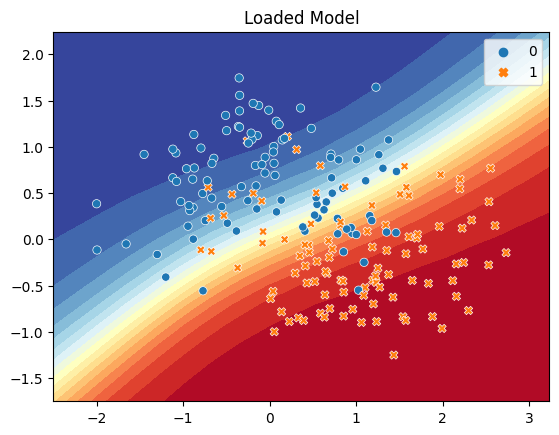

In [9]:
model_new = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)

visualize2DSoftmax(X_test, y_test, model_new, title="Initial Model")
plt.show()

checkpoint_dict = torch.load('model.pt', map_location=device)
model_new.load_state_dict(checkpoint_dict['model_state_dict'])
visualize2DSoftmax(X_test, y_test, model_new, title="Loaded Model")
plt.show()

<Axes: xlabel='epoch', ylabel='train Acc'>

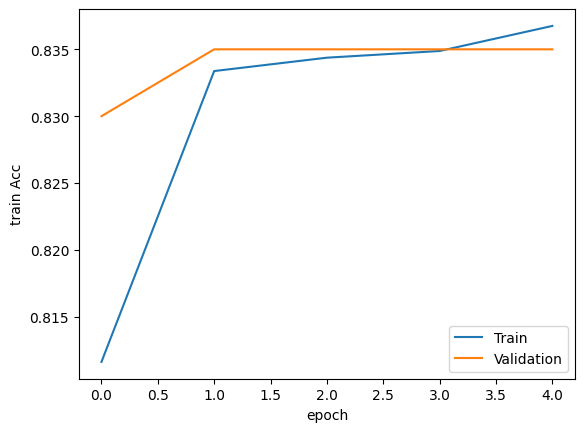

In [10]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd, label='Train')
sns.lineplot(x='epoch', y='test Acc', data=results_pd, label='Validation')

<Axes: xlabel='total time', ylabel='train F1'>

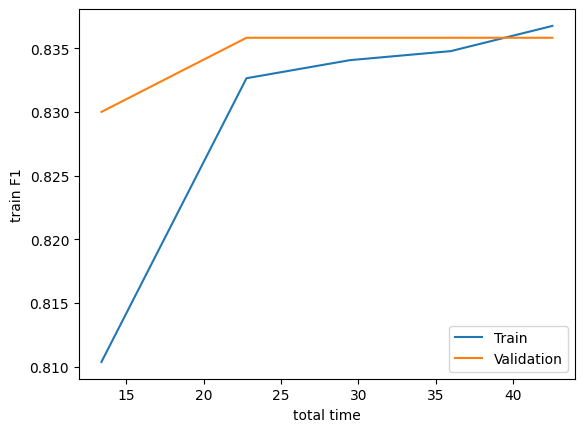

In [11]:
sns.lineplot(x='total time', y='train F1', data=results_pd, label='Train')
sns.lineplot(x='total time', y='test F1', data=results_pd, label='Validation')

In [12]:
training_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
model_gd = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_true_gd = train_simple_network(model_gd, loss_func, training_loader, epochs=5, test_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='total time', ylabel='test Acc'>

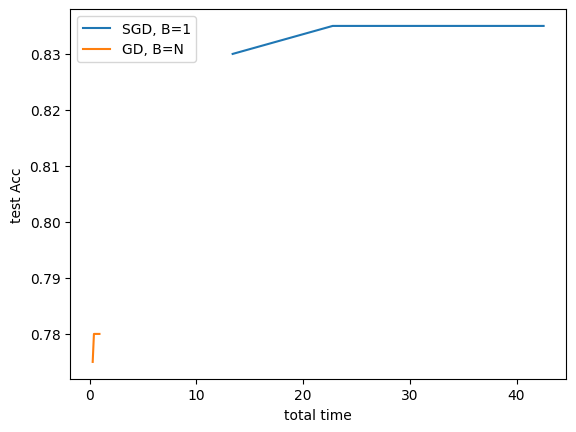

In [13]:
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='SGD, B=1')
sns.lineplot(x='total time', y='test Acc', data=results_true_gd, label='GD, B=N')

In [14]:
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model_sgd = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_batched = train_simple_network(model_sgd, loss_func, training_loader, epochs=5, test_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='total time', ylabel='test Acc'>

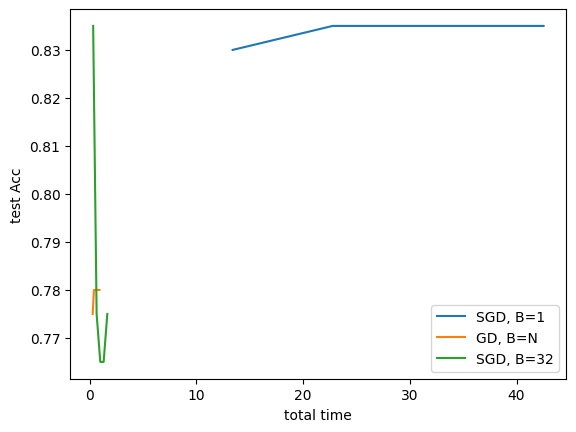

In [15]:
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='SGD, B=1')
sns.lineplot(x='total time', y='test Acc', data=results_true_gd, label='GD, B=N')
sns.lineplot(x='total time', y='test Acc', data=results_batched, label='SGD, B=32')